# Training a ML model (LSTF) to predict market data

Following this handy simple to understand tutorial https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning#stock_price_prediction we can easily create a barebones ML model for predicting market trajectory 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cryptoTracker.db.utils import init_pg_db , get_pg_db
init_pg_db()

initialising postgres db
connecting to winhost:5433


In [2]:
# load our training data from our db...
from cryptoTracker.application.queries.token import get_price_history

# using hardcoded token_id for testing...
df_history = get_price_history(token_id = 10)
df_history.head(2)

,token_id,date_open,date_close,price_open,price_close,price_high,price_low,volume,num_trades,periodicity
0,10,2022-01-01,2022-01-01 23:59:59,47723.335378,47723.335378,48295.378358,45607.098311,60674667.568629,545,D
1,10,2022-01-02,2022-01-02 23:59:59,47306.775195,47306.775195,48204.6,46640.06339,62486626.369609,478,D


In [3]:
len(df_history)

1559

In [4]:
# use our price_open for training...
# normalize our data points...
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(0,1))
scaled_training_set = scale.fit_transform(df_history.filter(['price_open']))

scaled_training_set

array([[0.60672853],
       [0.60022819],
       [0.5861201 ],
       ...,
       [0.81543808],
       [0.80420378],
       [0.81586732]])

In [5]:
scaled_training_set.shape

(1559, 1)

In [7]:
x = []
y = []

# grouping input in vstacks of n , 60 for inputting historical context...
for i in range(60,1559):
    x.append(scaled_training_set[i-60:i,0])
    y.append(scaled_training_set[i,0])
x = np.array(x)
y=np.array(y)
print(x.shape)
print(y.shape)

(1499, 60)
(1499,)


In [8]:
from sklearn.model_selection import train_test_split

x_test , x_train , y_test , y_train = train_test_split(x,y,test_size=0.33,random_state=42)

In [9]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(495, 60, 1)

In [10]:
from keras.models import Sequential
from keras.layers import(
LSTM, Dense , Dropout
)

2024-08-24 18:07:25.420994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-24 18:07:25.426691: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 18:07:25.456016: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 18:07:25.496544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 18:07:25.524763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [11]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1) ) )

# attempting to combat overfitting using a dropout element , randomly setting inputs to 0 at supplied step.
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))


/home/zionunix/Repos/cryptoTracker/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
regressor.compile(optimizer='adam' , loss='mean_squared_error')
regressor.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1151
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0194
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0074
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0061
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0060
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0054
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0055
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0058
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0053
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0046
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0051
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0056
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0047
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0060
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - lo

In [13]:
total_inputs = df_history.price_open.values
total_inputs = total_inputs.reshape(-1,1)

total_inputs = scale.transform(total_inputs)

inputs_x = []
for i in range(60,len(total_inputs)  + 1):
    inputs_x.append(total_inputs[i-60:i,0])
inputs_x = np.array(inputs_x)
inputs_x = np.reshape(inputs_x, (inputs_x.shape[0],inputs_x.shape[1],1) )

/home/zionunix/Repos/cryptoTracker/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [14]:
predicted_price = regressor.predict(inputs_x)
predicted_price = scale.inverse_transform(predicted_price)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [15]:
df_plot = df_history.filter(['date_open', 'price_open'])

In [16]:
len(predicted_price)

1500

In [17]:
df_plot = df_plot[59:]

In [18]:
df_plot['predicted_price_open'] = list(predicted_price)

In [19]:
df_plot = df_plot.astype({
    'predicted_price_open' : 'Float64'
})

In [20]:
df_plot

,date_open,price_open,predicted_price_open
59,2021-08-12,44480.899012,42552.78125
60,2021-08-13,47750.925911,44454.195312
61,2021-08-14,47281.869135,45785.636719
62,2020-05-18,9750.102807,43045.050781
63,2020-05-19,9739.541525,37340.519531
...,...,...,...
1554,2024-08-19,59462.159656,56790.375
1555,2024-08-20,59121.042311,56793.410156
1556,2024-08-21,61098.034142,57110.136719
1557,2024-08-22,60378.108883,57550.417969


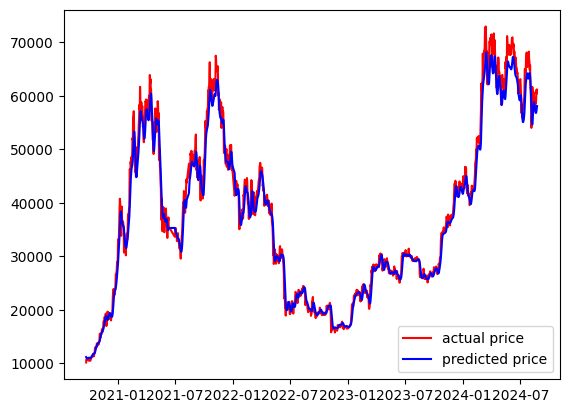

In [21]:
plt.plot(df_plot.date_open[100:],df_plot.price_open[100:], color='red', label='actual price')
plt.plot(df_plot.date_open[100:],df_plot.predicted_price_open[100:], color='blue', label='predicted price')
plt.legend()

# serializing model ...